In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from astropy.constants import c
from scipy.fftpack import fft, fftfreq
c = c.value*1e-6 #Speed of light in mm/ns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import scipy.optimize as op
from scipy.stats import chi2
import emcee
import corner
import h5py

1). Load in all the data. Specify which files represent the one arm scans and which ones represent the actual
data set. The hdf5_name variable specifies which group inside a larger hdf5 file you'd want the current data set
to be stored. This is for later ease of combining data from multiple runs without having to analyze the data from scratch.

In [2]:
hdf5_name = '/15-02-5/150/X'
save_name = '15-02-5_150_X'
datadir = '../data/15-02-5 150GHz Xpol/'

# Flags for the data analysis
fit95GHz = False # Toggle between 95 and 150 GHz
saveplots = False #Turn on/off plotting
useonearm = True #One arm scans were taken
usesincfitting = True #Use sinc fitting. Almost always True

files = glob(datadir + '*.txt') 
if useonearm:
    no_sample_one_arm_scans = [0,1,2]# [0,1,2]
    sample_one_arm_scans = [3,4,5]# [0,1,2]
no_sample_scans = range(6, len(files),2)
sample_scans = range(7, len(files),2)

In [3]:
# Now we can load all of the data
scans = dict()
scans['L'] = 3.25*25.4 # thickness of the etalon in mm
scans['no-sample'] = dict()
scans['sample'] = dict()
if useonearm:
    scans['no-sample']['one-arm'] = dict()
    scans['sample']['one-arm'] = dict()

scans_signal = []
scans_encoder = []
for i, f in enumerate(files):
    index, time, encoder, signal = np.loadtxt(f, comments='#', skiprows=14, unpack=True)
    scans_signal += [signal]
    scans_encoder += [encoder]
print("I have loaded {0} files".format(i))
    
scans_signal = np.array(scans_signal)
scans_encoder = np.array(scans_encoder)
if useonearm:
    scans['no-sample']['one-arm']['signal'] = scans_signal[no_sample_one_arm_scans]
    scans['no-sample']['one-arm']['encoder'] = scans_encoder[no_sample_one_arm_scans]
    scans['sample']['one-arm']['signal'] = scans_signal[sample_one_arm_scans]
    scans['sample']['one-arm']['encoder'] = scans_encoder[sample_one_arm_scans]
scans['no-sample']['signal'] = scans_signal[no_sample_scans]
scans['sample']['signal'] = scans_signal[sample_scans]
scans['no-sample']['encoder'] = scans_encoder[no_sample_scans]
scans['sample']['encoder'] = scans_encoder[sample_scans]

I have loaded 18 files


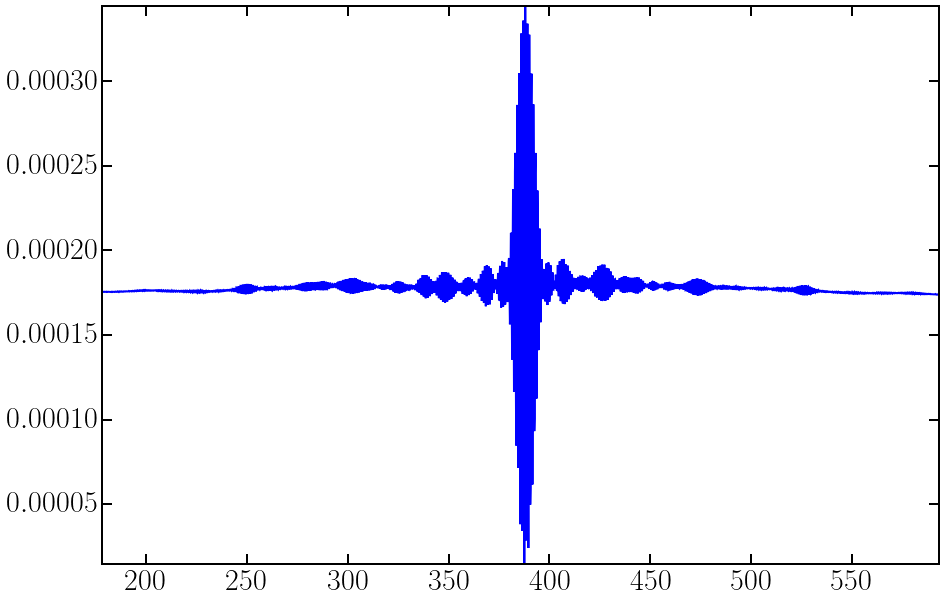

In [4]:
i = 5
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['sample']['encoder'][i], scans['sample']['signal'][i]);
ax.axis('tight');
if saveplots: plt.savefig(save_name + 'raw_interferogram.png')

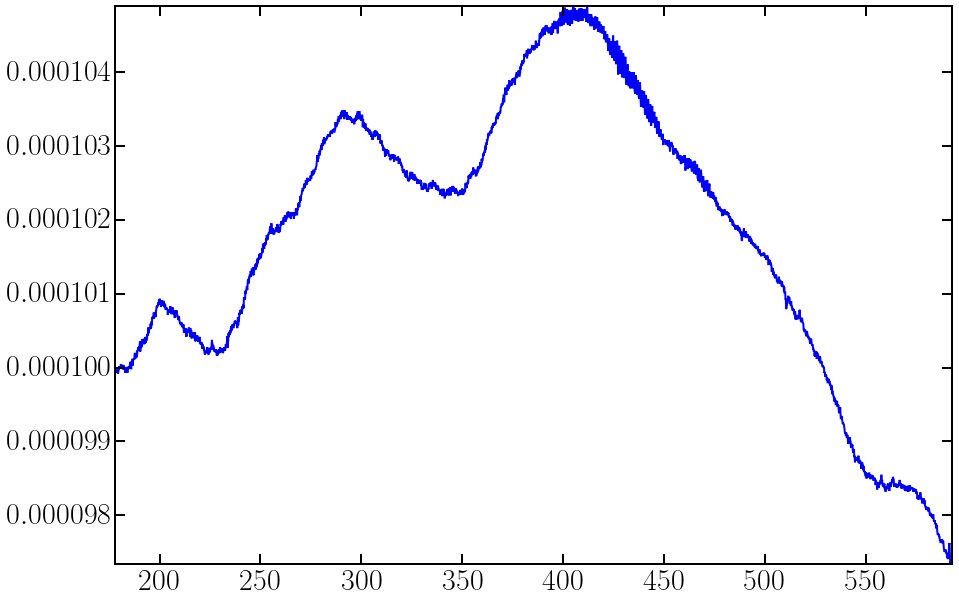

In [5]:
if useonearm:
    scans['no-sample']['one-arm']['signal-averaged'] = np.average(scans['no-sample']['one-arm']['signal'], axis=0)
    scans['no-sample']['one-arm']['encoder-averaged'] = np.average(scans['no-sample']['one-arm']['encoder'], axis=0)

    scans['sample']['one-arm']['signal-averaged'] = np.average(scans['sample']['one-arm']['signal'], axis=0)
    scans['sample']['one-arm']['encoder-averaged'] = np.average(scans['sample']['one-arm']['encoder'], axis=0)

    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(scans['no-sample']['one-arm']['encoder-averaged'], scans['no-sample']['one-arm']['signal-averaged']);
    ax.axis('tight');

2). Use the one arm scans to subtract out the drift in the interferogram. Once the one-arm contribution is subtracted off, subtract out the mean to get rid of the DC component of the FFT. If no one-arm scans were taken, you can use a 
convolution method to correct for the drift.

In [6]:
N = scans['no-sample']['signal'].shape[0]
print scans['no-sample']['signal'].shape[1]
signal_driftcorr = []
encoder_driftcorr = []
for i in xrange(N):
    if useonearm:
        driftcorr = (scans['no-sample']['signal'][i] - scans['no-sample']['one-arm']['signal-averaged'])
        driftcorr -= np.average(driftcorr)
        signal_driftcorr += [driftcorr]
        encoder_driftcorr += [scans['no-sample']['encoder'][i]]
    else:
        driftcorr = scans['no-sample']['signal'][i]
        driftcorr /= np.sqrt(scans['one-arm']['signal-averaged'])
        peak = scans['no-sample']['encoder'][i][np.where(driftcorr == max(driftcorr))[0]][0]
        # Change this to be correct for the convolution
        thresh = np.logical_and(scans['no-sample']['encoder'][i] > (peak - 1.5), scans['no-sample']['encoder'][i] < (peak + 1.5))
        Nmask = 400
        mask = np.ones(Nmask)
        avg = np.convolve(driftcorr, mask, 'same')/Nmask
        driftcorr = driftcorr[thresh] - avg[thresh]
        encoder_driftcorr += [scans['no-sample']['encoder'][i][thresh]]
        

scans['no-sample']['encoder-driftcorrected'] = np.array(encoder_driftcorr)
scans['no-sample']['signal-driftcorrected'] = np.array(signal_driftcorr)
scans['no-sample']['signal-averaged'] = np.average(signal_driftcorr, axis=0)

2676


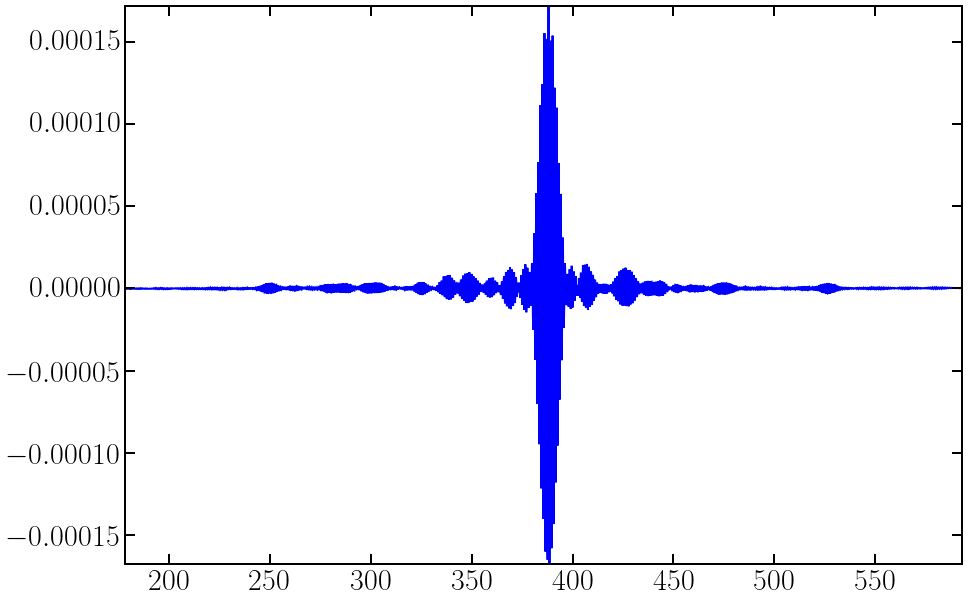

In [7]:
i = 0
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['no-sample']['encoder-driftcorrected'][i], scans['no-sample']['signal-driftcorrected'][i]);
ax.axis('tight');
mydata = np.c_[scans['no-sample']['encoder-driftcorrected'][i], scans['no-sample']['signal-driftcorrected'][i]]
np.savetxt('f.txt', mydata, '%10s')
if saveplots: plt.savefig(save_name + 'driftcorrected_interferogram.png')

In [8]:
N = scans['sample']['signal'].shape[0]
print scans['sample']['signal'].shape[1]
signal_driftcorr = []
encoder_driftcorr = []
for i in xrange(N):
    if useonearm:
        driftcorr = (scans['sample']['signal'][i] - scans['sample']['one-arm']['signal-averaged'])
        driftcorr -= np.average(driftcorr)
        signal_driftcorr += [driftcorr]
        encoder_driftcorr += [scans['sample']['encoder'][i]]
    else:
        driftcorr = scans['sample']['signal'][i]
        driftcorr /= np.sqrt(scans['one-arm']['signal-averaged'])
        peak = scans['sample']['encoder'][i][np.where(driftcorr == max(driftcorr))[0]][0]
        # Change this to be correct for the convolution
        thresh = np.logical_and(scans['sample']['encoder'][i] > (peak - 1.5), scans['sample']['encoder'][i] < (peak + 1.5))
        Nmask = 400
        mask = np.ones(Nmask)
        avg = np.convolve(driftcorr, mask, 'same')/Nmask
        driftcorr = driftcorr[thresh] - avg[thresh]
        encoder_driftcorr += [scans['sample']['encoder'][i][thresh]]
        

scans['sample']['encoder-driftcorrected'] = np.array(encoder_driftcorr)
scans['sample']['signal-driftcorrected'] = np.array(signal_driftcorr)
scans['sample']['signal-averaged'] = np.average(signal_driftcorr, axis=0)

2676


3). Correct for the position of the peak. Using a sinc function fit,we calculate the actual path difference between the two arms of the FTS.

In [9]:
# Fit functions for the interferogram peak
def quadraticfit(x, A, B, C):
    return A*x**2 + B*x + C
def sincfit(x, A, B, C, D):
    return A*(np.sinc(B*x+C))*np.cos(D*x)
def envelope(x, A, B, C):
    return A*(np.sinc(B*x+C)) 

for the scan 0 the position of zero p.d is 388.042938
for the scan 1 the position of zero p.d is 388.043444
for the scan 2 the position of zero p.d is 388.049544
for the scan 3 the position of zero p.d is 388.046699
for the scan 4 the position of zero p.d is 388.049812
for the scan 5 the position of zero p.d is 388.040407
for the scan 6 the position of zero p.d is 388.052787


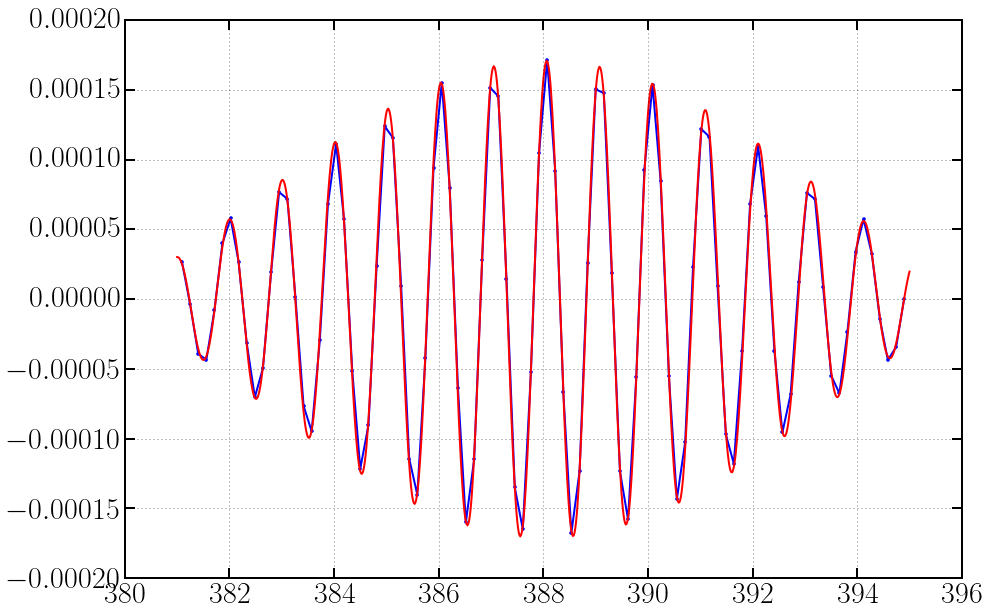

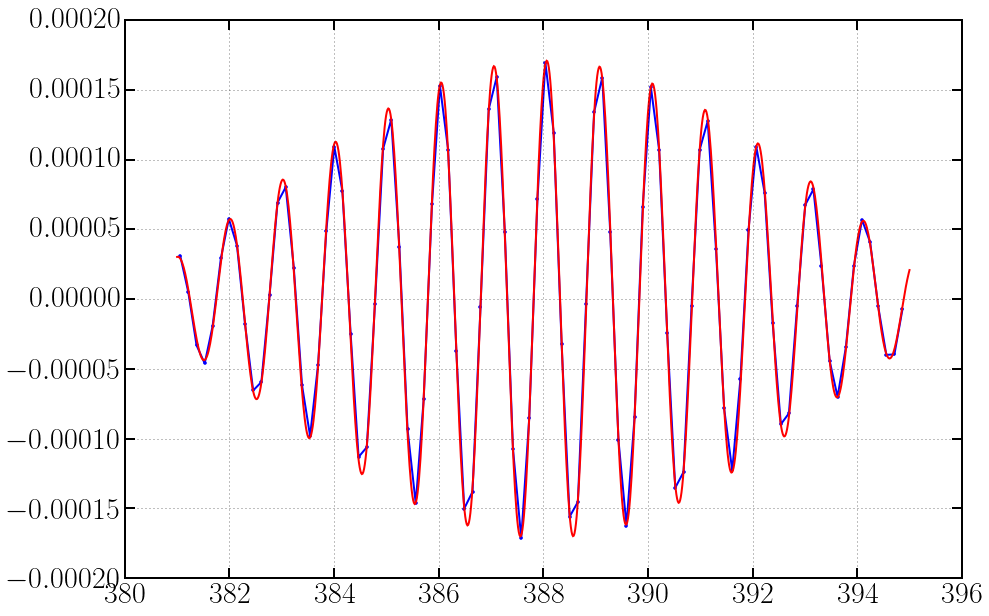

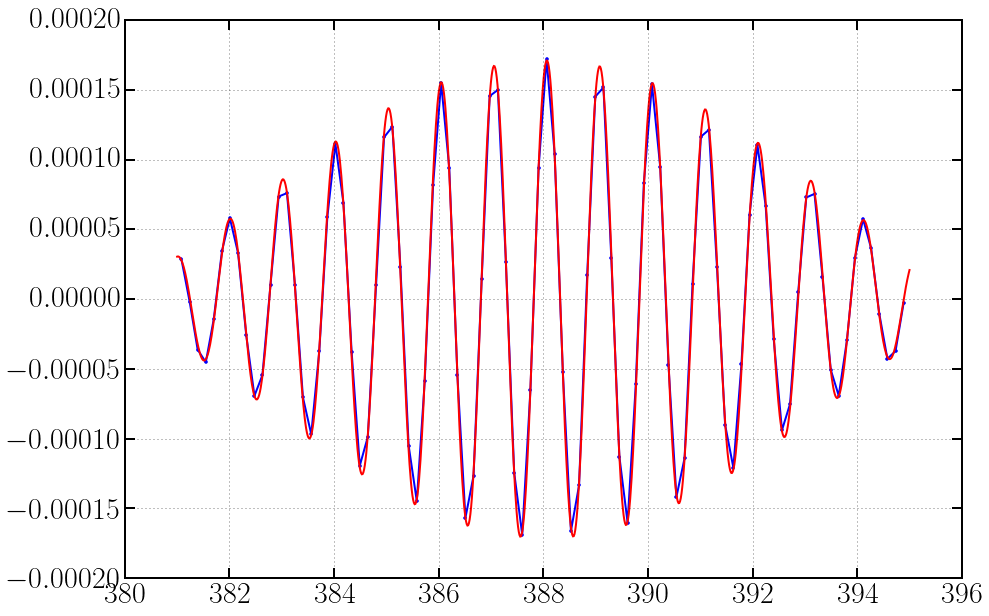

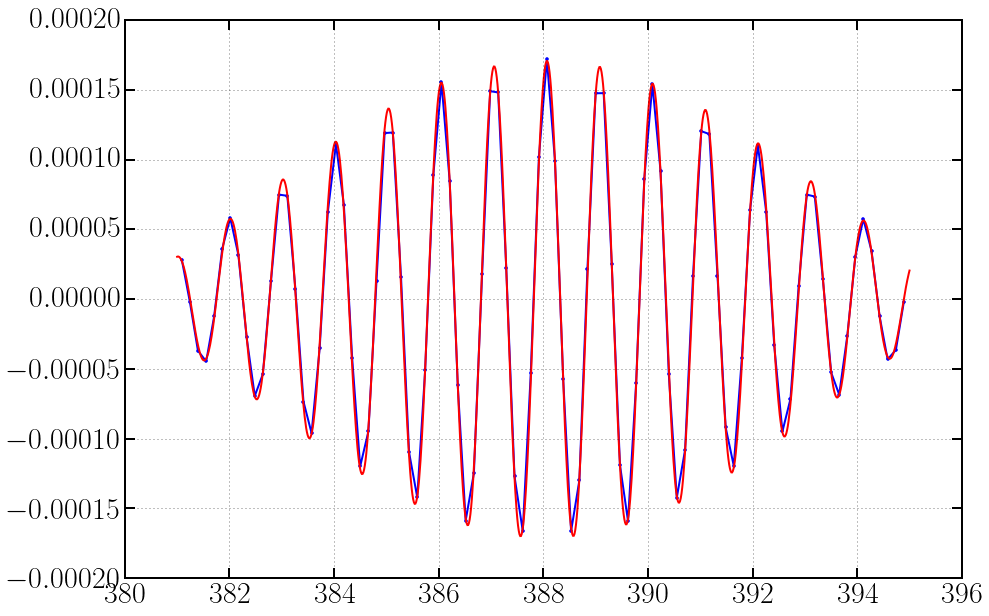

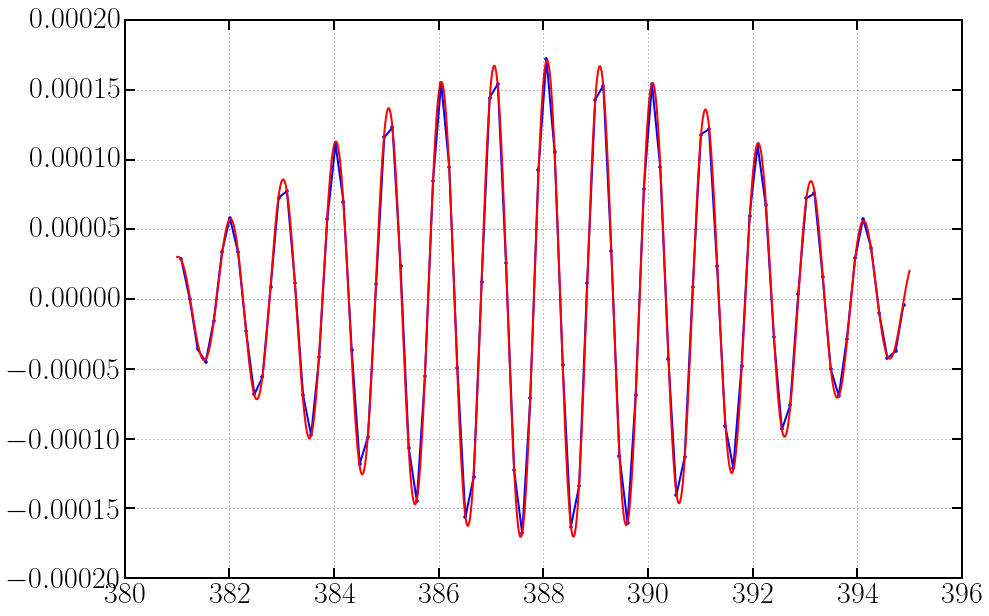

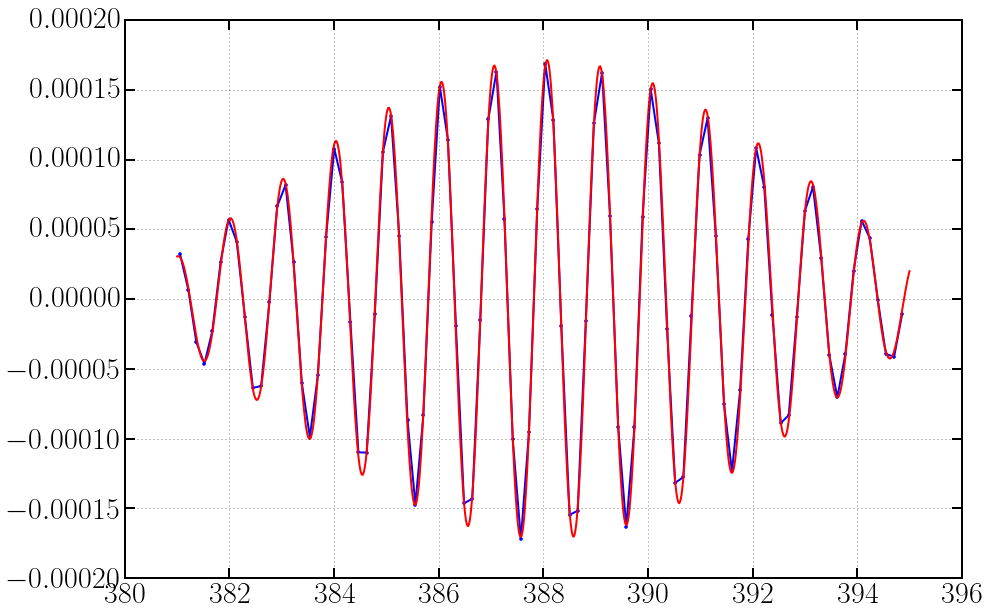

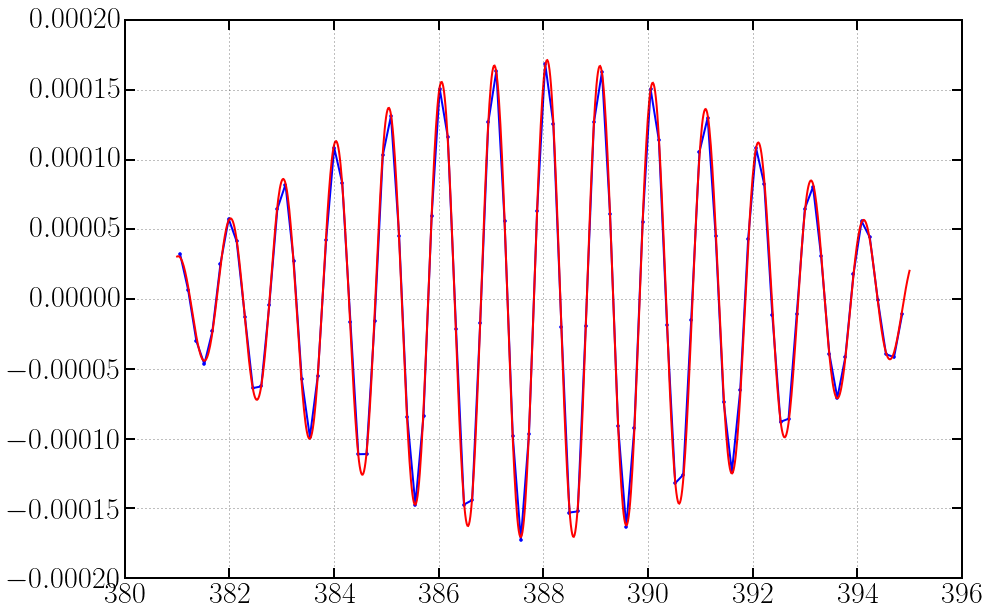

In [10]:
# First Find the right position of the origin of the interferogram
N = scans['no-sample']['signal-driftcorrected'].shape[0]
if not usesincfitting: fig, ax =plt.subplots(figsize=(15,10))
# initial guess for the parameters #
if fit95GHz: 
    parameter_initial = np.array([1.5e-4,40/c,-51.6,1190./c]) #for 95 GHz
else:
    parameter_initial = np.array([1.5e-4,40/c,-51.6,1862.3/c])5#for 150GHz
    
for i in xrange(N):
    if usesincfitting:
        xdata = scans['no-sample']['encoder-driftcorrected'][i]
        ydata = scans['no-sample']['signal-driftcorrected'][i]
        mask=np.logical_and(scans['no-sample']['encoder-driftcorrected'][i]>=381,\
                            scans['no-sample']['encoder-driftcorrected'][i]<=395)
        xdata=scans['no-sample']['encoder-driftcorrected'][i][mask] #mask the unwanted data
        ydata=scans['no-sample']['signal-driftcorrected'][i][mask]
        parameter_optimal, covariance = curve_fit(sincfit, xdata, ydata, p0=parameter_initial)
        actual_peak = -parameter_optimal[2]/parameter_optimal[1]
        print("for the scan %d the position of zero p.d is %1.6f" %(i, actual_peak))
        
        
    #     y= envelope(xdata,*parameter_optimal[:-1])
        xnew = np.r_[381:395:1000j]
        y= sincfit(xnew,*parameter_optimal)
        fig, ax = plt.subplots(figsize=(15,10))
        ax.plot(xdata, ydata, 'b.-')
        ax.plot(xnew, y, 'r-')
    #     ax.plot(xdata, -y, 'r-')
        ax.grid(which='major')
#         ax.set_xlim(381,395)
    else:
        peak = np.where(scans['no-sample']['signal-driftcorrected'][i] ==\
                        max(scans['no-sample']['signal-driftcorrected'][i]))[0][0]
        y = scans['no-sample']['signal-driftcorrected'][i][peak-1: peak+2]
        x = scans['no-sample']['encoder-driftcorrected'][i][peak-1:peak+2]
        X = np.vstack([x**2, x, np.ones_like(x)]).T
        A = np.linalg.solve(X, y)
        actual_peak = -A[1]/(2*A[0])
        sig_peak = quadratic(actual_peak, *list(A))
        pltlabel = r'%d' %i
        ax.plot(x, y, '+', markersize=20)
        xs = np.linspace(scans['no-sample']['encoder-driftcorrected'][i][peak-2],\
                         scans['no-sample']['encoder-driftcorrected'][i][peak+2],100)
        ax.plot(xs, quadratic(xs, *list(A)), label=pltlabel)
        ax.legend(loc='best')
        ax.axis('tight')
        
    scans['no-sample']['encoder-driftcorrected'][i] -= actual_peak
    scans['no-sample']['encoder-driftcorrected'][i] *= (2/c) # Encoder now represents the path length difference
    
if saveplots: plt.savefig(save_name + 'no-sample_peakmatching.png')

for the scan 0 the position of zero p.d is 388.050881
for the scan 1 the position of zero p.d is 388.046992
for the scan 2 the position of zero p.d is 388.048226
for the scan 3 the position of zero p.d is 388.044829
for the scan 4 the position of zero p.d is 388.046570
for the scan 5 the position of zero p.d is 388.055174


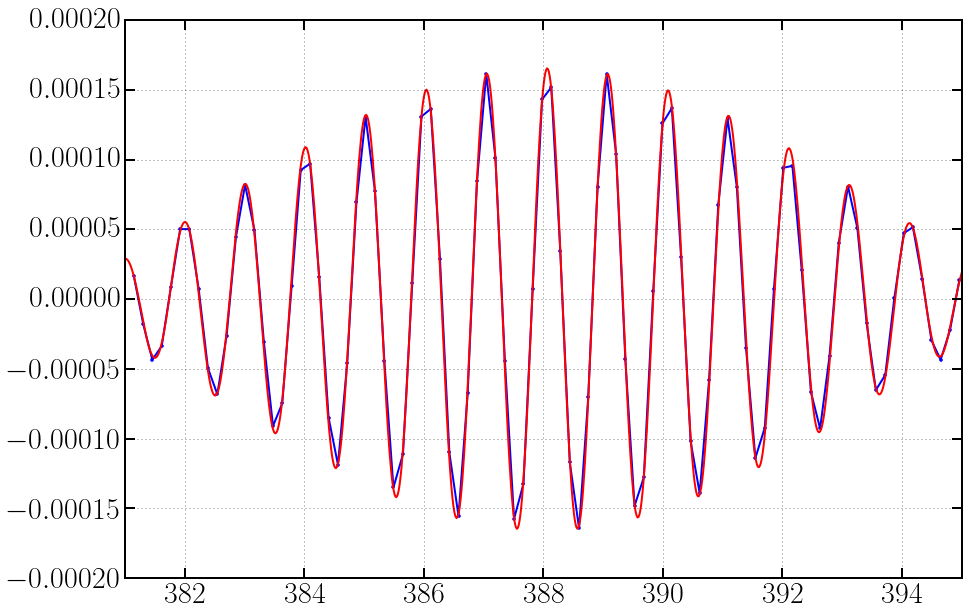

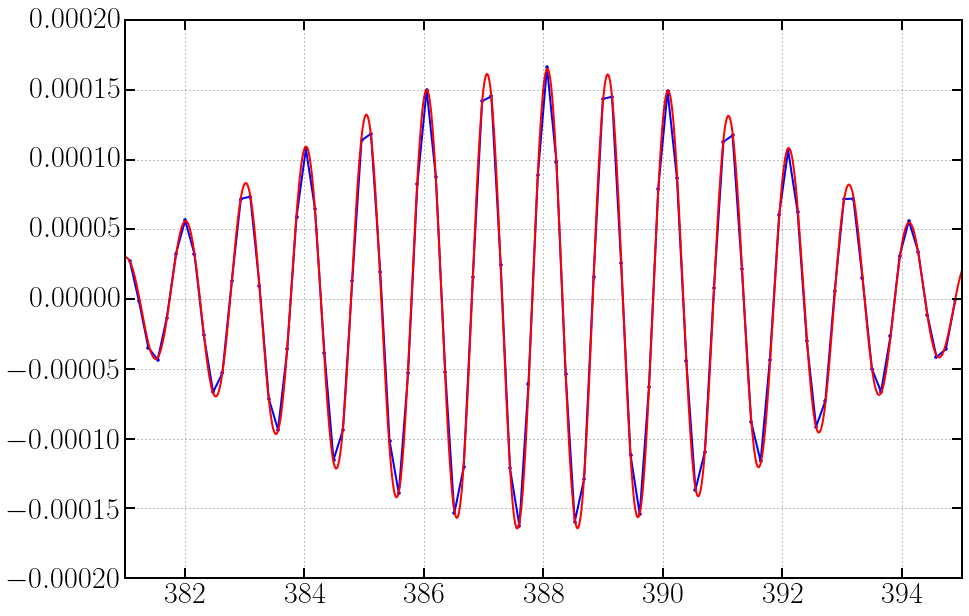

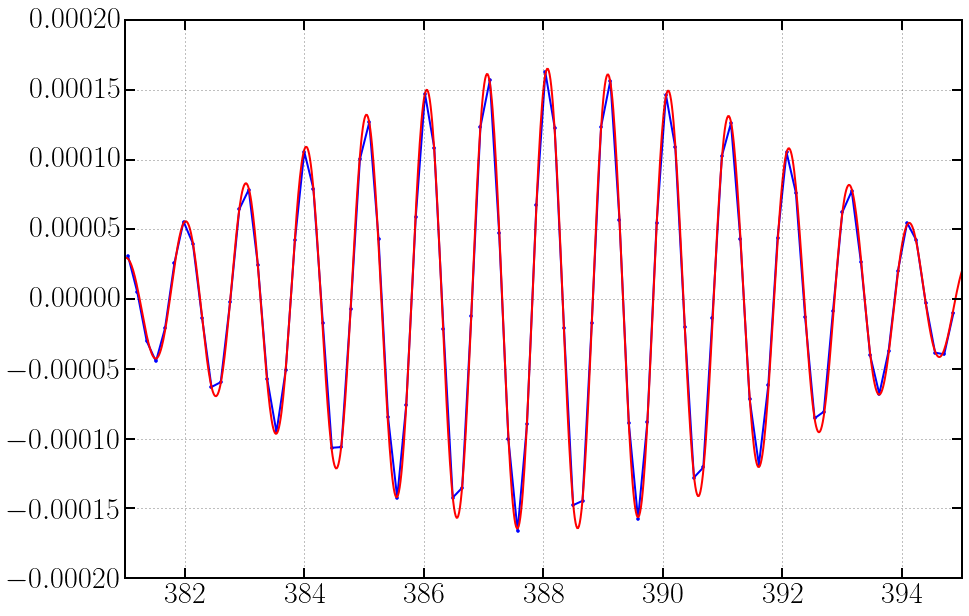

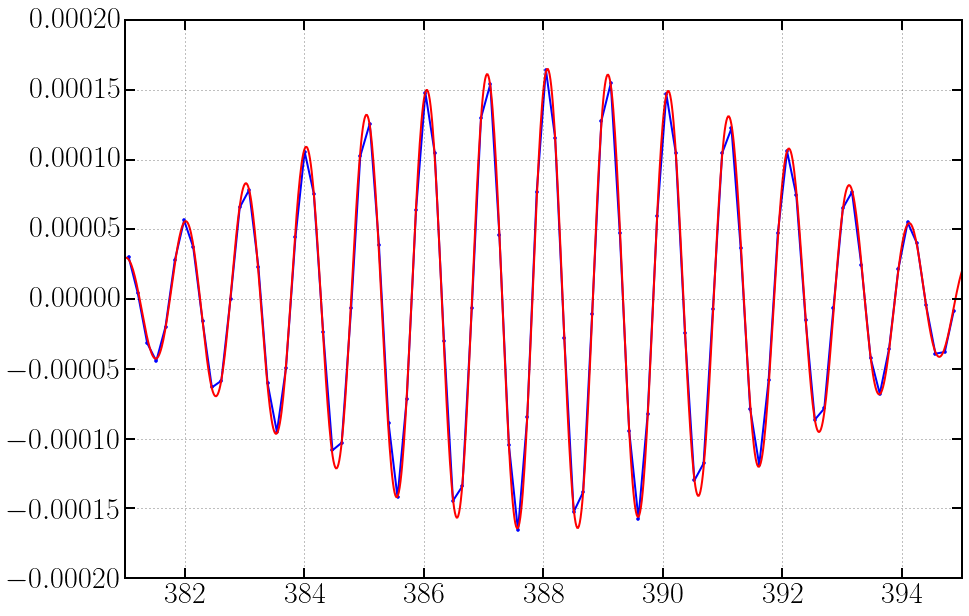

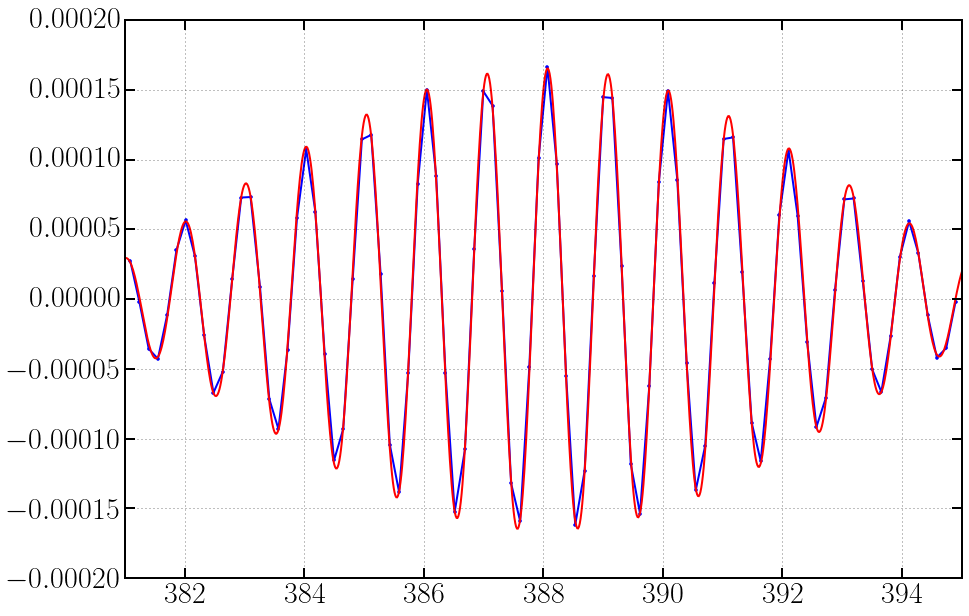

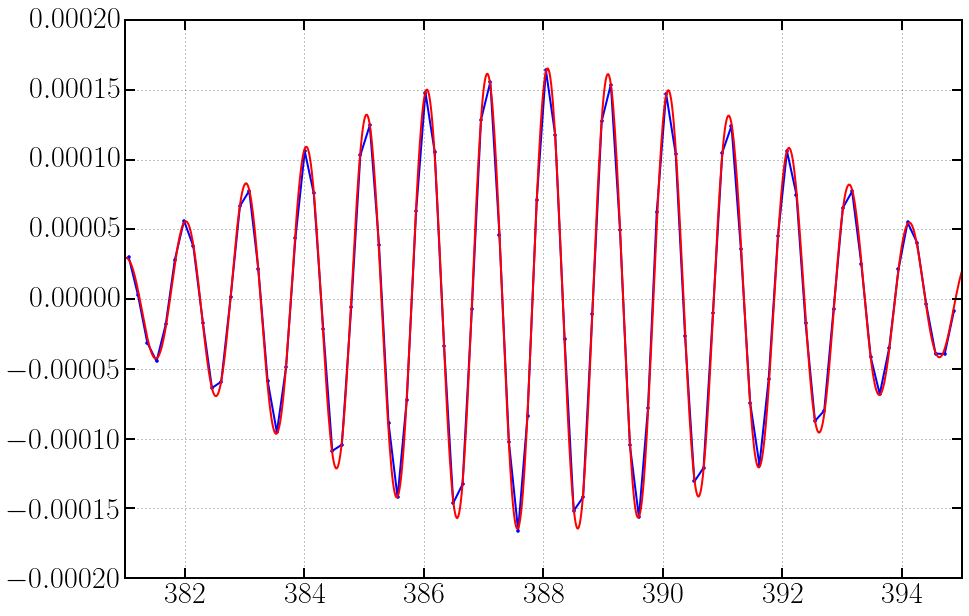

In [11]:
# First Find the right position of the origin of the interferogram
N = scans['sample']['signal-driftcorrected'].shape[0]
if not usesincfitting: fig, ax =plt.subplots(figsize=(15,10))
    
# initial guess for the parameters #
if fit95GHz: 
    parameter_initial = np.array([1.5e-4,40/c,-51.6,1190./c]) #for 95 GHz
else:
    parameter_initial = np.array([1.5e-4,40/c,-51.6,1862.3/c]) #for 150GHz
    
for i in xrange(N):
    if usesincfitting:
        xdata = scans['sample']['encoder-driftcorrected'][i]
        ydata = scans['sample']['signal-driftcorrected'][i]
        mask=np.logical_and(scans['sample']['encoder-driftcorrected'][i]>=381,\
                            scans['sample']['encoder-driftcorrected'][i]<=395)
        xdata=scans['sample']['encoder-driftcorrected'][i][mask] #mask the unwanted data
        ydata=scans['sample']['signal-driftcorrected'][i][mask]
        parameter_optimal, covariance = curve_fit(sincfit, xdata, ydata, p0=parameter_initial)
        actual_peak = -parameter_optimal[2]/parameter_optimal[1]
        print("for the scan %d the position of zero p.d is %1.6f" %(i, actual_peak))
    #     y= envelope(xdata,*parameter_optimal[:-1])
        xnew = np.r_[381:395:1000j]
        y= sincfit(xnew,*parameter_optimal)
        fig, ax = plt.subplots(figsize=(15,10))
        ax.plot(xdata, ydata, 'b.-')
        ax.plot(xnew, y, 'r-')
    #     ax.plot(xdata, -y, 'r-')
        ax.grid(which='major')
        ax.set_xlim(381,395)
    else:
        peak = np.where(scans['sample']['signal-driftcorrected'][i] ==\
                        max(scans['sample']['signal-driftcorrected'][i]))[0][0]
        y = scans['sample']['signal-driftcorrected'][i][peak-1: peak+2]
        x = scans['sample']['encoder-driftcorrected'][i][peak-1:peak+2]
        X = np.vstack([x**2, x, np.ones_like(x)]).T
        A = np.linalg.solve(X, y)
        actual_peak = -A[1]/(2*A[0])
        sig_peak = quadratic(actual_peak, *list(A))
        pltlabel = r'%d' %i
        ax.plot(x, y, '+', markersize=20)
        xs = np.linspace(scans['sample']['encoder-driftcorrected'][i][peak-2],\
                         scans['sample']['encoder-driftcorrected'][i][peak+2],100)
        ax.plot(xs, quadratic(xs, *list(A)), label=pltlabel)
        ax.legend(loc='best')
        ax.axis('tight')
        
    scans['sample']['encoder-driftcorrected'][i] -= actual_peak
    scans['sample']['encoder-driftcorrected'][i] *= (2/c) # Encoder now represents the path length difference
    
if saveplots: plt.savefig(save_name + 'sample_peakmatching.png')

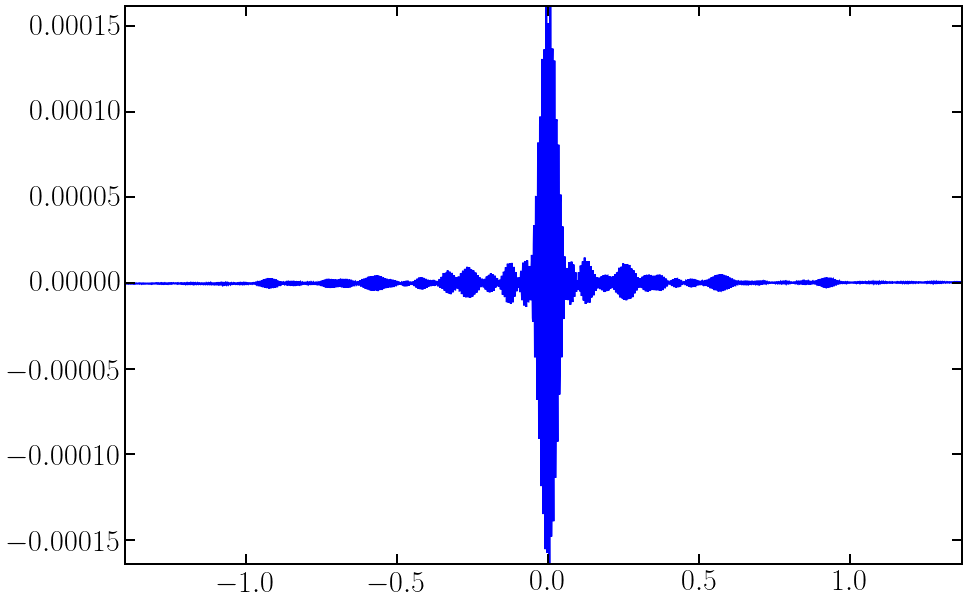

In [12]:
i = 0
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['sample']['encoder-driftcorrected'][i], scans['sample']['signal-driftcorrected'][i]);
ax.axis('tight');
# ax.set_xlim(-0.2, 0.2)
if saveplots: plt.savefig(save_name + 'peakcorrected-interferogram.png')

4) Use interpolation to resample the interferogram as an evenly spaced array of $2^n$ data points. The spacing is chosen such that the data point at $2^{n-1}$ is the one of zero path difference. The resulting array is circularly symmetric i.e: $x[i] = x[-i] \text{ for } i = 1,2,...,n-1$. 

In [13]:
n = 15
k = 10.0
m = k*2**(1 - n)
encoder_new = m*np.arange(0, 2**n + 1) - k
scans['encoder-resampled'] = encoder_new[:-1]
print len(scans['encoder-resampled'])

32768


In [14]:
N = scans['no-sample']['signal'].shape[0]
signal_new = []
for i in xrange(N):
    f = interp1d(scans['no-sample']['encoder-driftcorrected'][i], scans['no-sample']['signal-driftcorrected'][i],\
                 kind='cubic', bounds_error=False, fill_value=0.0)
    signal_new += [f(scans['encoder-resampled'])]
    print "Finished working on the %d scan" %i
scans['no-sample']['signal-resampled'] = np.array(signal_new)

Finished working on the 0 scan
Finished working on the 1 scan
Finished working on the 2 scan
Finished working on the 3 scan
Finished working on the 4 scan
Finished working on the 5 scan
Finished working on the 6 scan


In [15]:
N = scans['sample']['signal'].shape[0]
signal_new = []
for i in xrange(N):
    f = interp1d(scans['sample']['encoder-driftcorrected'][i], scans['sample']['signal-driftcorrected'][i],\
                 kind='cubic', bounds_error=False, fill_value=0.0)
    signal_new += [f(scans['encoder-resampled'])]
    print "Finished working on the %d scan" %i
scans['sample']['signal-resampled'] = np.array(signal_new)

Finished working on the 0 scan
Finished working on the 1 scan
Finished working on the 2 scan
Finished working on the 3 scan
Finished working on the 4 scan
Finished working on the 5 scan


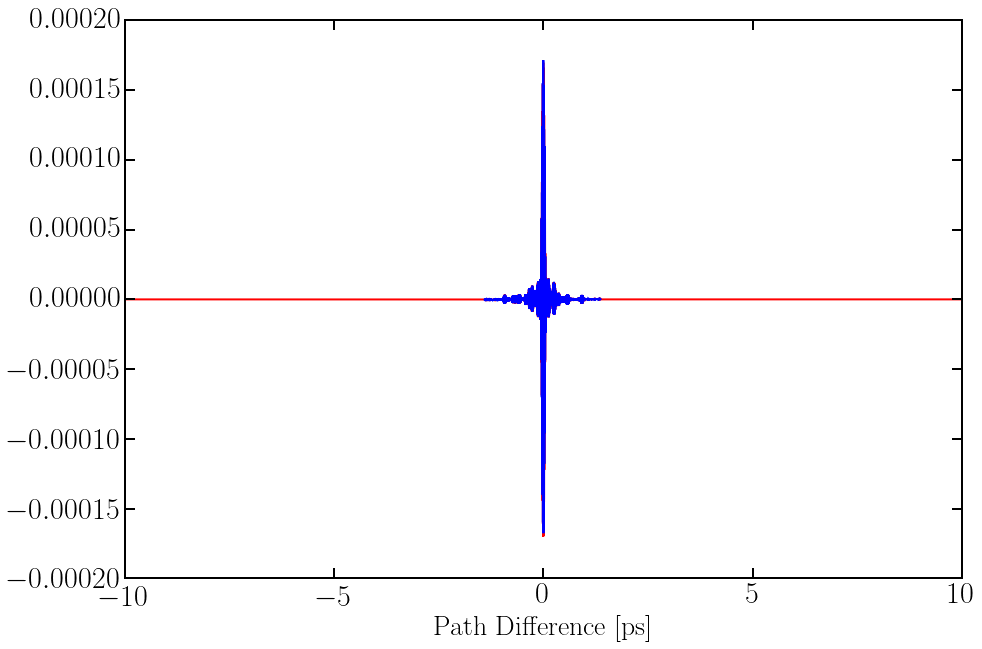

In [16]:
i = 0
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['encoder-resampled'], (scans['no-sample']['signal-resampled'][i]), 'r');
ax.plot(scans['no-sample']['encoder-driftcorrected'][i], (scans['no-sample']['signal-driftcorrected'][i]), 'b');
ax.set_xlabel('Path Difference [ps]')
if saveplots: plt.savefig(save_name + 'zeropadded-interferogram.png')

5) Now we can compute the FFT of the interferograms. The real part of the FFT is what is used to computed the ratio of the spectra.

In [17]:
N = scans['no-sample']['signal'].shape[0]
dx = (scans['encoder-resampled'][1] - scans['encoder-resampled'][0])
ffts = []
scans['k'] = fftfreq(len(scans['no-sample']['signal-resampled'][0]), dx)
for i in xrange(N):
    y = fft((scans['no-sample']['signal-resampled'][i]))
    Ny = len(y)
    ffts += [y]
scans['no-sample']['signal-fft'] = np.array(ffts)

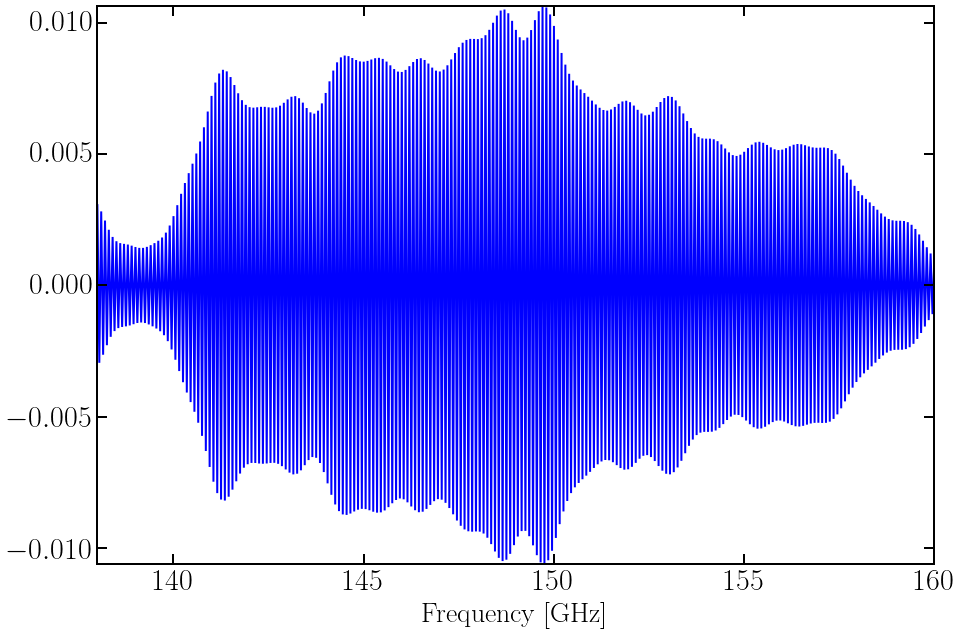

In [18]:
i = 0
fig, ax = plt.subplots(figsize=(15,10))
if fit95GHz:
    scans['thresh'] = np.logical_and(scans['k'] >= 89, scans['k'] <= 100.5) #For 95 GHz
else:
    scans['thresh'] = np.logical_and(scans['k'] >= 138, scans['k'] <= 160)
ax.plot(scans['k'][scans['thresh']], np.real(scans['no-sample']['signal-fft'][i])[scans['thresh']]);
ax.set_xlabel('Frequency [GHz]')
ax.axis('tight');

In [19]:
N = scans['sample']['signal'].shape[0]
dx = (scans['encoder-resampled'][1] - scans['encoder-resampled'][0])
ffts = []
for i in xrange(N):
    y = fft((scans['sample']['signal-resampled'][i]))
    Ny = len(y)
    ffts += [y]
scans['sample']['signal-fft'] = np.array(ffts)

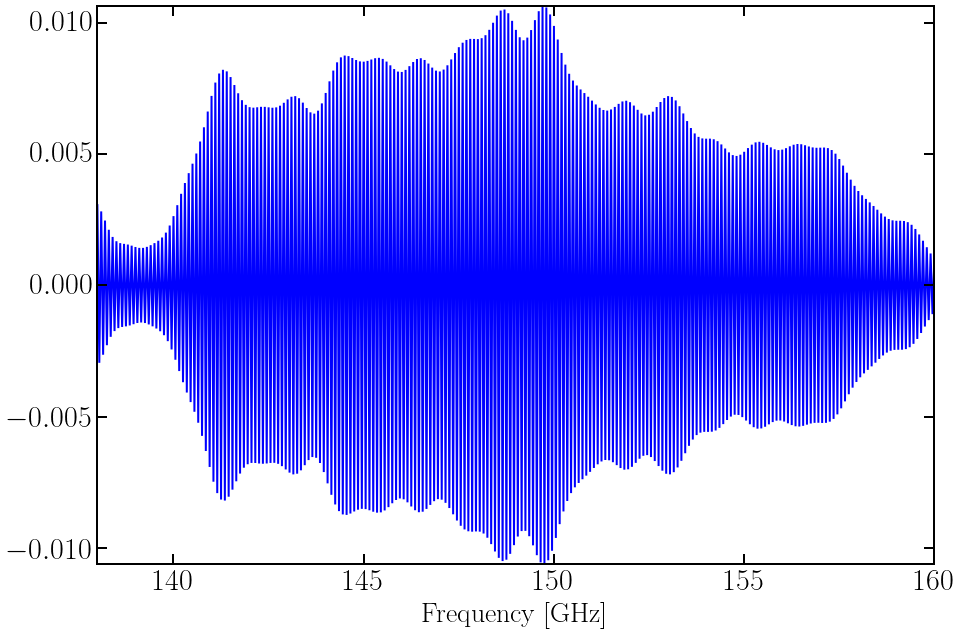

In [20]:
i = 0
fig, ax = plt.subplots(figsize=(15,10))
# scans['thresh'] = np.logical_and(scans['k'] >= 130, scans['k'] <= 170)
ax.plot(scans['k'][scans['thresh']], np.real(scans['no-sample']['signal-fft'][i])[scans['thresh']]);
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]');

In [21]:
scans['no-sample']['fft-averaged'] = np.mean(np.real(scans['no-sample']['signal-fft'][1:]), axis=0)
scans['no-sample']['fft-error'] = np.std(np.real(scans['no-sample']['signal-fft'][1:]), axis=0)
scans['sample']['fft-averaged'] = np.mean(np.real(scans['sample']['signal-fft'][1:]), axis=0)
scans['sample']['fft-error'] = np.std(np.real(scans['sample']['signal-fft'][1:]), axis=0)

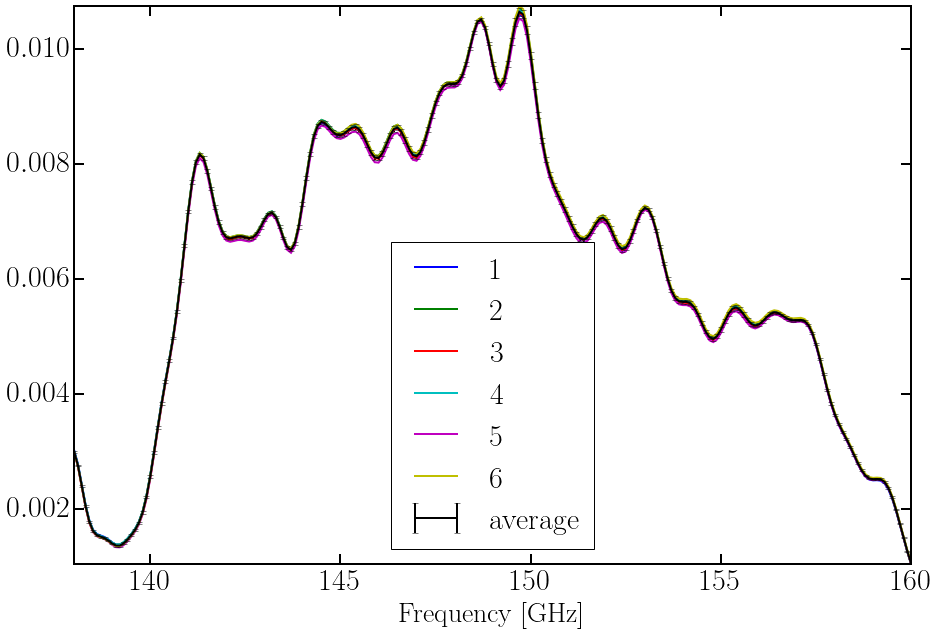

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
N = scans['no-sample']['signal'].shape[0]
for i in xrange(1, N):
    pltlabel = r'%d' %i
    ax.plot(scans['k'][scans['thresh']][::2],\
            np.real(scans['no-sample']['signal-fft'][i])[scans['thresh']][::2], label=pltlabel)
ax.errorbar(scans['k'][scans['thresh']][::2],\
            (scans['no-sample']['fft-averaged'])[scans['thresh']][::2],\
            yerr = (scans['no-sample']['fft-error'])[scans['thresh']][::2], label="average",\
           fmt='-', ecolor='k', color='k')
ax.legend(loc='best');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
if saveplots: plt.savefig(save_name + 'no-sample_fft.png')

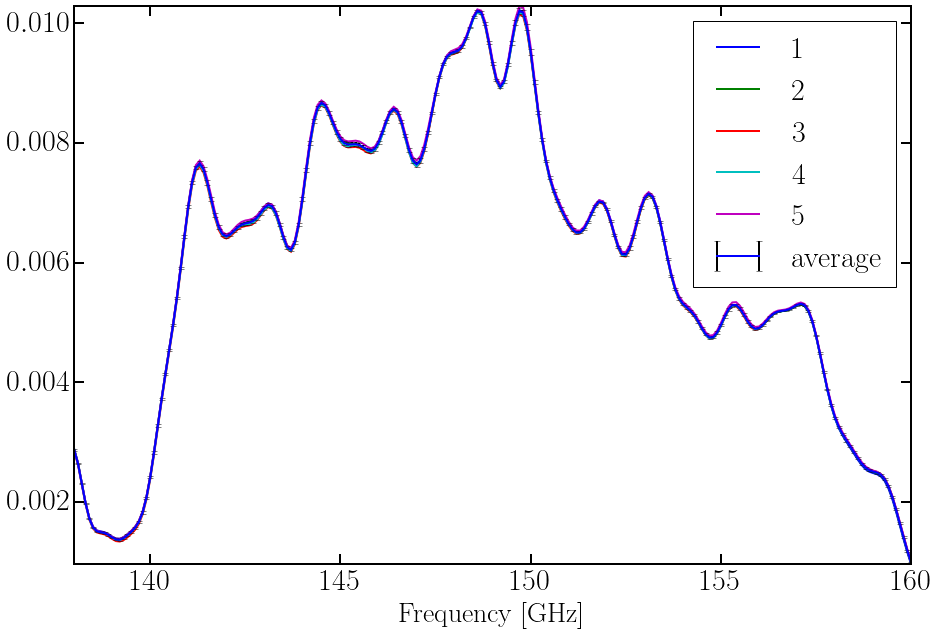

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
N = scans['sample']['signal'].shape[0]
for i in xrange(1, N):
    pltlabel = r'%d' %i
    ax.plot(scans['k'][scans['thresh']][::2], np.real(scans['sample']['signal-fft'][i])[scans['thresh']][::2], label=pltlabel)
ax.errorbar(scans['k'][scans['thresh']][::2], (scans['sample']['fft-averaged'])[scans['thresh']][::2],\
            yerr = (scans['sample']['fft-error'])[scans['thresh']][::2], label="average",\
           fmt='-', ecolor='k', color='blue')
ax.legend(loc='best');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
if saveplots: plt.savefig(save_name + 'sample_fft.png')

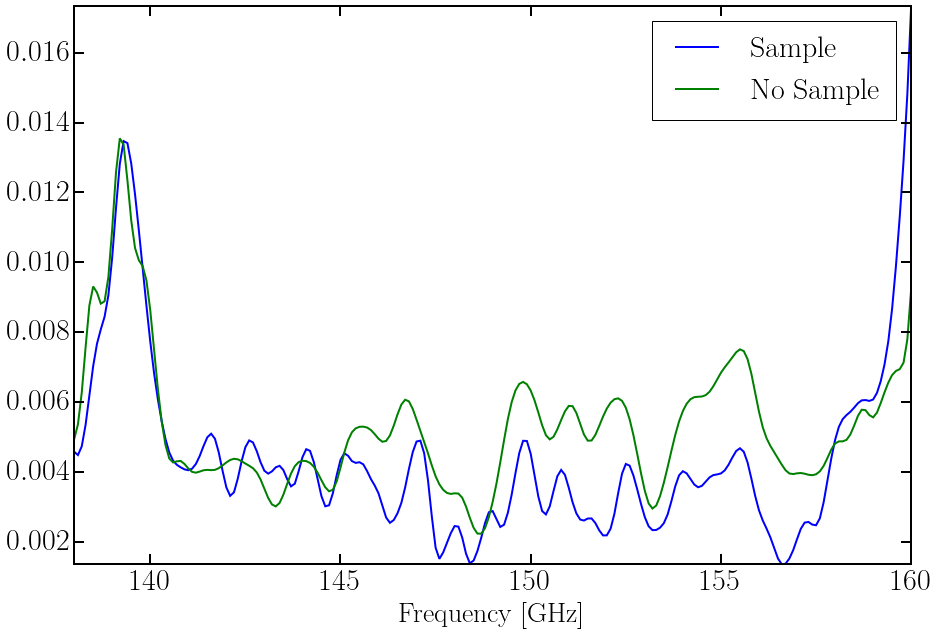

In [24]:
scans['sample']['relative-error'] = np.real(scans['sample']['fft-error'])/np.real(scans['sample']['fft-averaged'])
scans['no-sample']['relative-error'] = np.real(scans['no-sample']['fft-error'])/np.real(scans['no-sample']['fft-averaged'])
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(scans['k'][scans['thresh']][::2], scans['sample']['relative-error'][scans['thresh']][::2], label='Sample')
ax.plot(scans['k'][scans['thresh']][::2], scans['no-sample']['relative-error'][scans['thresh']][::2], label='No Sample')
ax.legend(loc='best');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
if saveplots: plt.savefig(save_name + 'relative_error.png')

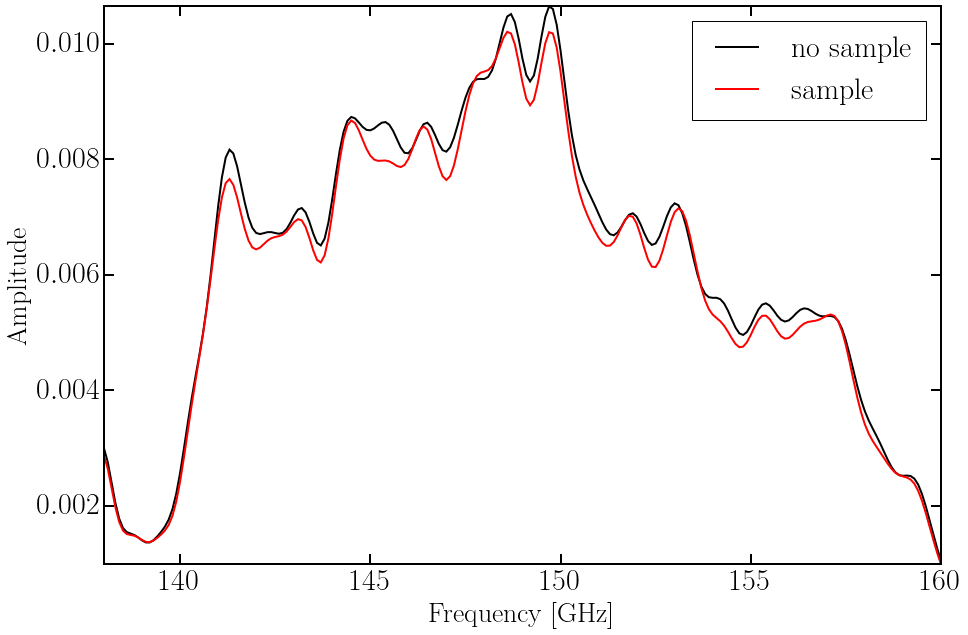

In [25]:
i = 2
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(scans['k'][scans['thresh']][::2], np.real(scans['no-sample']['fft-averaged'][scans['thresh']][::2]), 'k', label='no sample')
ax.plot(scans['k'][scans['thresh']][::2], np.real(scans['sample']['fft-averaged'][scans['thresh']][::2]), 'r', label='sample');
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Amplitude');
ax.legend(loc='best');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
if saveplots: plt.savefig(save_name + 'no-sample_vs_sample_fft.png')

In [26]:
scans['ratio'] = np.real(scans['sample']['fft-averaged'])/np.real(scans['no-sample']['fft-averaged'])
scans['ratio-error'] = scans['ratio']*\
np.sqrt((scans['sample']['relative-error'])**2 + \
        (scans['no-sample']['relative-error'])**2 )

6) Fit for the FP fringes. First, based on the relative error in the plot above, select a region of the band where the error is not excessively high. Fit the region based on the transmission model below. Use MLE fitting to extract out the parameters of the best fit.

In [27]:
if fit95GHz:
    scans['fit-thresh'] = np.logical_and(scans['k'] >= 90,\
                                         scans['k'] <= 100) #For 95 GHz
else:
    scans['fit-thresh'] = np.logical_and(scans['k'] >= 140,\
                                         scans['k'] <= 159) #For 150 GHz

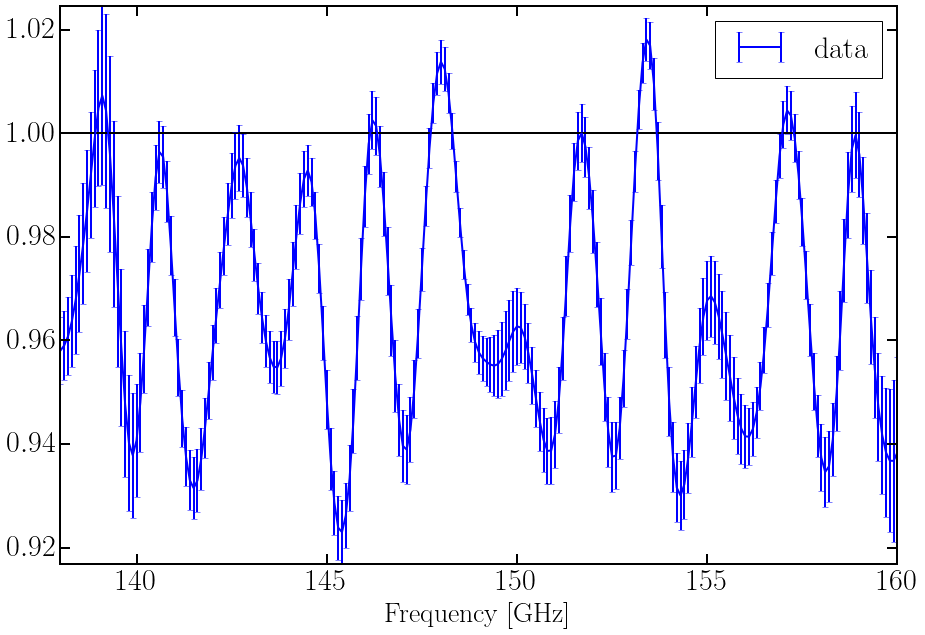

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
ax.errorbar(scans['k'][scans['thresh']][::2], scans['ratio'][scans['thresh']][::2],\
            yerr=scans['ratio-error'][scans['thresh']][::2], fmt='b-', ecolor='b', label='data');
kmin = scans['k'][scans['thresh']][0]
kmax = scans['k'][scans['thresh']][-1]
# ax.plot(scans['k'][scans['thresh']], scans['ratio'][scans['thresh']]);
ax.hlines(1.0, kmin, kmax, colors='k', linestyles='solid');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
ax.legend(loc='best');

if saveplots: plt.savefig(save_name + 'fringes_with_ebars.png');

In [29]:
def transmissionModel(nu, R, T, L, C):
    A = (T/(1-R))**2
    F = 4*R/(1-R)**2
    B = 2*2*np.pi/c*L*scans['L']
    return A*1./(1 + F * np.sin((B*nu + C*np.pi)/2)**2)

def lnlike(theta, x, y, yerr):
    model = transmissionModel(x, *theta)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

def chisq(theta, x, y, yerr):
    N = len(x)
    return -2.0*lnlike(theta, x, y, yerr)

def pvalue(chisqval, dof):
    return chi2.sf(chisqval, dof)

nll = lambda *args: -lnlike(*args) #Negative Log Likelihood

In [30]:
R = 0.02
L = np.cos(3*np.pi/180)
C = 1.0
T = 0.98

guesses = [R, T, L, C]

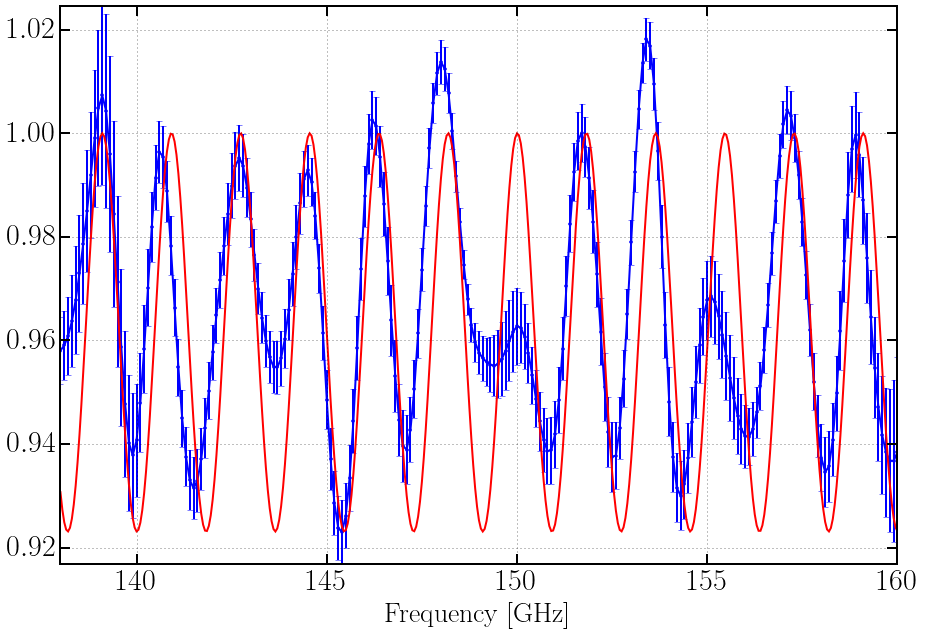

In [31]:
fig, ax = plt.subplots(figsize=(15,10))

ax.errorbar(scans['k'][scans['thresh']][::2], scans['ratio'][scans['thresh']][::2],\
            yerr=scans['ratio-error'][scans['thresh']][::2], fmt='b.-', ecolor='b');

ax.plot(scans['k'][scans['thresh']], transmissionModel(scans['k'][scans['thresh']], *guesses), 'r-');
ax.axis('tight');
ax.grid(which='major')
ax.set_xlabel('Frequency [GHz]')
if saveplots: plt.savefig(save_name + 'guess_fringes_with_ebars.png')

In [32]:
N = len(scans['k'][scans['fit-thresh']])
dof = N - len(guesses)
print dof
# Minimize the negative log likelihood to maximize the log likelihood.
result = op.minimize(nll, guesses, args=(scans['k'][scans['fit-thresh']], scans['ratio'][scans['fit-thresh']],\
                                         scans['ratio-error'][scans['fit-thresh']]), method='Powell')#, \
#                      bounds=[(0,1.0), (0,1.0),(0.5*(4*np.pi/c)*scans['L'],\
#                                                1.5*(4*np.pi/c)*scans['L']),(-2.0*np.pi, 2.0*np.pi)])
R_ml, T_ml, L_ml, phi_ml = result["x"]

chisqval = chisq(result['x'], scans['k'][scans['fit-thresh']],\
                    scans['ratio'][scans['fit-thresh']],\
                    scans['ratio-error'][scans['fit-thresh']])
chisqreduced = chisqval/dof
pval = pvalue(chisqval, dof)
print result['message'] + """Parameters extracted with a reduced chi-square
                            value of {0:4.5f} and a p-value {1:4.5f}""".format(chisqreduced, pval)
scans['chisq'] = chisqreduced
print "optimal parameters are: R = {params[0]}, T = {params[1]}, L= {params[2]}, C = {params[3]}".format(params=result['x'])

377
Optimization terminated successfully.Parameters extracted with a reduced chi-square
                            value of 5.61009 and a p-value 0.00000
optimal parameters are: R = 0.0146093943723, T = 0.985367472381, L= 0.999576560753, C = 1.01929031446


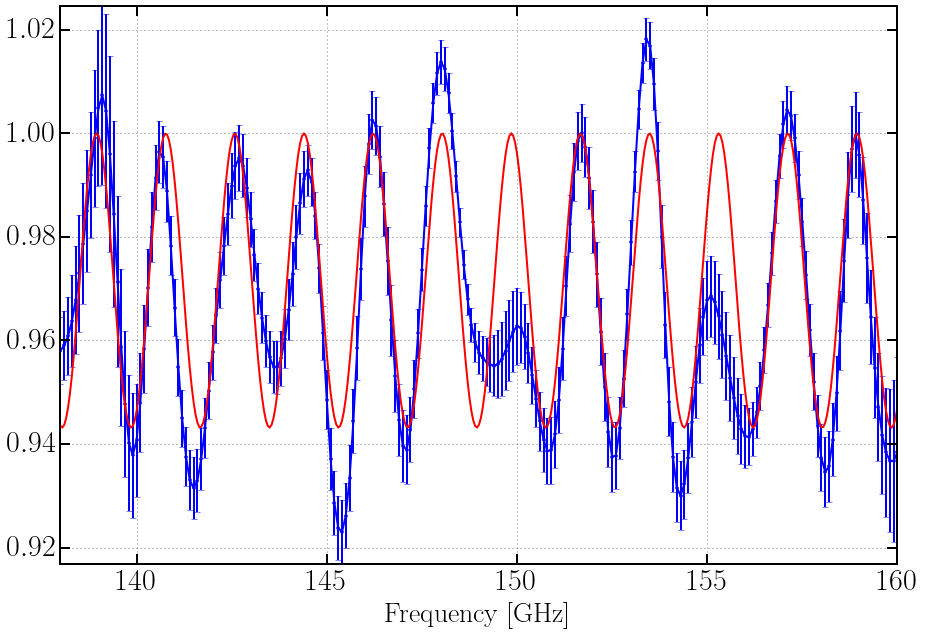

In [33]:
fig, ax = plt.subplots(figsize=(15,10))

ax.errorbar(scans['k'][scans['thresh']][::2], scans['ratio'][scans['thresh']][::2],\
            yerr=scans['ratio-error'][scans['thresh']][::2], fmt='b.-', ecolor='b');

ax.plot(scans['k'][scans['thresh']], transmissionModel(scans['k'][scans['thresh']], *result["x"]), 'r-');
ax.grid(which='major')
ax.axis('tight')
ax.set_xlabel('Frequency [GHz]')
if saveplots: plt.savefig(save_name + 'minimize_fringes_with_ebars.png')

7). Use MCMC to estimate the uncertainty on the parameters that we just extracted. To do so, we define some priors on the parameters. Just used uniform distributions.

In [34]:
def lnprior(theta):
    R, T, L, C = theta
#     print("Sum of R and T is {0} and L is {1} while C is {2} ".format(R + T, L, C))
    if (0.0 < R < 1.0 and
        0.0 < T < 1.0 and
        0.0 < R + T <= 1.0 and 
        0.5 < L < 1.5 and
        -2.0 < C < 2.0) :
        return 0.0
    else:
        return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [35]:
ndim, nwalkers = 4, 1000
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [36]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(scans['k'][scans['fit-thresh']], scans['ratio'][scans['fit-thresh']],\
                                         scans['ratio-error'][scans['fit-thresh']]))

In [37]:
nsteps = 2000
sampler.run_mcmc(pos, nsteps);

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


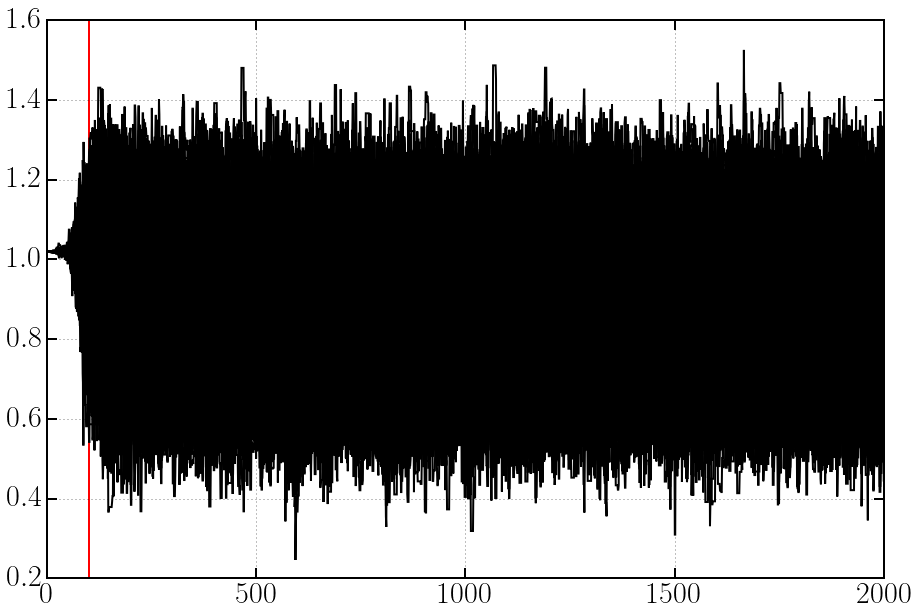

In [38]:
# print (result["x"][0] + result["x"][1])
# lprob = lnlike(pos[500], scans['k'][scans['fit-thresh']],\
#        scans['ratio'][scans['fit-thresh']],scans['ratio-error'][scans['fit-thresh']])
# print(lprob)
# sampler.chain[0,:,0].shape
fig,ax = plt.subplots(figsize=(15,10))
for i in xrange(nwalkers):
    ax.plot(sampler.chain[i,:,3], 'k')
__, __, ymin, ymax = ax.axis()
ax.vlines(100, ymin,ymax,color=u'r')
ax.axis('tight')
ax.grid(which='both');

In [39]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
print samples.shape

(1900000, 4)


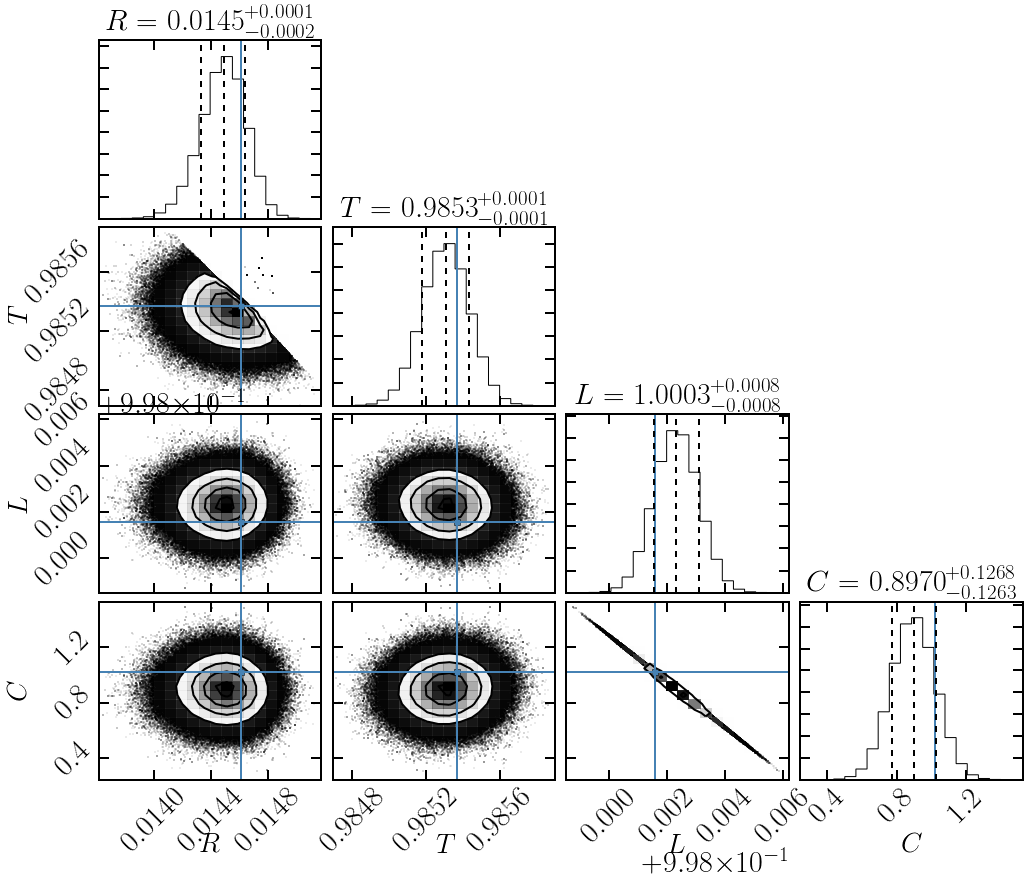

In [40]:
figure, ax = plt.subplots(nrows = ndim, ncols=ndim, figsize=(15,12))
fig = corner.corner(samples, title_fmt='.4f',labels=["$R$", "$T$", "$L$", "$C$"],\
                      truths=result["x"], quantiles=[.16, .50, .84],\
                    fig=figure,show_titles=True, use_math_text=True)
if saveplots: fig.savefig(save_name + 'corner_plot.png')

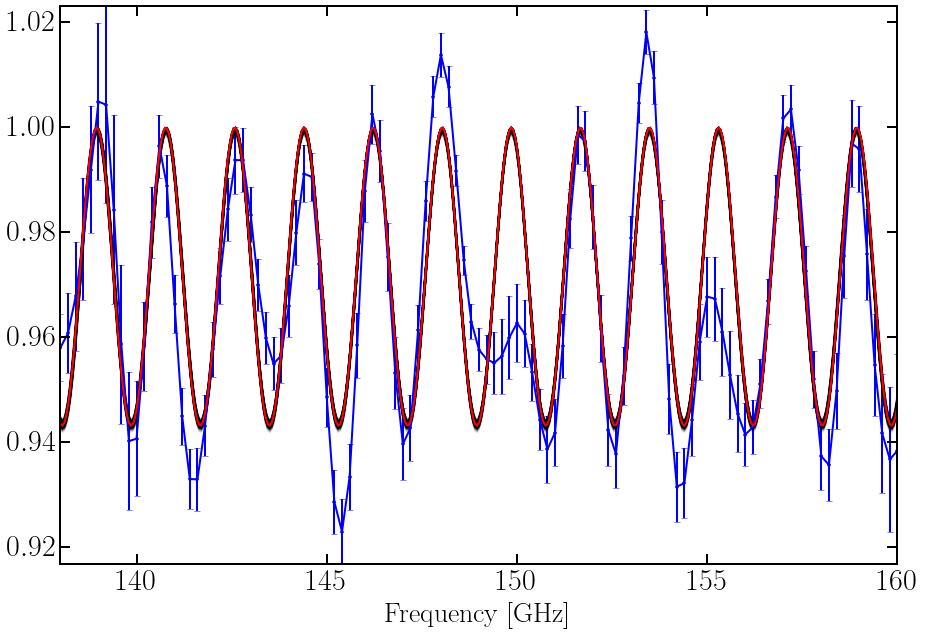

In [41]:
fig,ax = plt.subplots(figsize=(15,10))
for opt in samples[np.random.randint(len(samples), size=200)]:
    ax.plot(scans['k'][scans['thresh']],\
            transmissionModel(scans['k'][scans['thresh']],*opt), color="k", alpha=0.1)
# ax.plot(scans['k'][scans['thresh']], transmissionModel(scans['k'][scans['thresh']],*guesses), color="r", alpha=0.8)
ax.errorbar(scans['k'][scans['thresh']][::4], scans['ratio'][scans['thresh']][::4],\
            yerr=scans['ratio-error'][scans['thresh']][::4], fmt="b.-",ecolor='b', label='data')
ax.plot(scans['k'][scans['thresh']], transmissionModel(scans['k'][scans['thresh']], *result["x"]),\
        'r-', label='MLE Fit');
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]')
if saveplots: plt.savefig(save_name + 'projected-space.png')

In [42]:
R_mcmc, T_mcmc, L_mcmc, C_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
A_mcmc = (1-(R_mcmc[0] + T_mcmc[0]), ((R_mcmc[1]**2 + T_mcmc[1]**2))**0.5, (R_mcmc[2]**2 + T_mcmc[2]**2)**0.5)
scans['R_mcmc'] = R_mcmc
scans['T_mcmc'] = T_mcmc
scans['A_mcmc'] = A_mcmc
scans['L_mcmc'] = L_mcmc
scans['C_mcmc'] = C_mcmc

In [ ]:
scans.keys()

In [ ]:
hdf5_name = '/15-02-5/150/X'
datafile = h5py.File('mesh_filters.hdf5','a')
base_name = hdf5_name.split('/')[1]
try:
    curr_grp = datafile[hdf5_name]
except KeyError:
    curr_grp = datafile.create_group(hdf5_name)
datafile.close()

In [ ]:
base_name

In [ ]:
print ("R MCMC is {0}".format(R_mcmc))
print ("T MCMC is {0}".format(T_mcmc))
print ("A MCMC is {0}".format(A_mcmc))
print ("L MCMC is {0}".format(L_mcmc))
print ("C MCMC is {0}".format(C_mcmc))

In [ ]:
zip(*np.percentile(samples, [16, 50, 84],axis=0))

In [ ]:
np.percentile(samples, [16, 50, 84],axis=0)